# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import simplefilter
simplefilter("ignore")

train = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv', index_col='id')
train = train.dropna(subset=['num_sold'])
train

,date,country,store,product,num_sold
id,,,,,
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0
...,...,...,...,...,...
230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0


In [2]:
train['date'] = pd.to_datetime(train['date'])
train['month'] = train['date'].dt.month
train['year_month'] = train['date'].dt.to_period('M').astype('str')
train['day_of_week'] = train['date'].dt.dayofweek
train['week_of_year'] = train['date'].dt.isocalendar().week

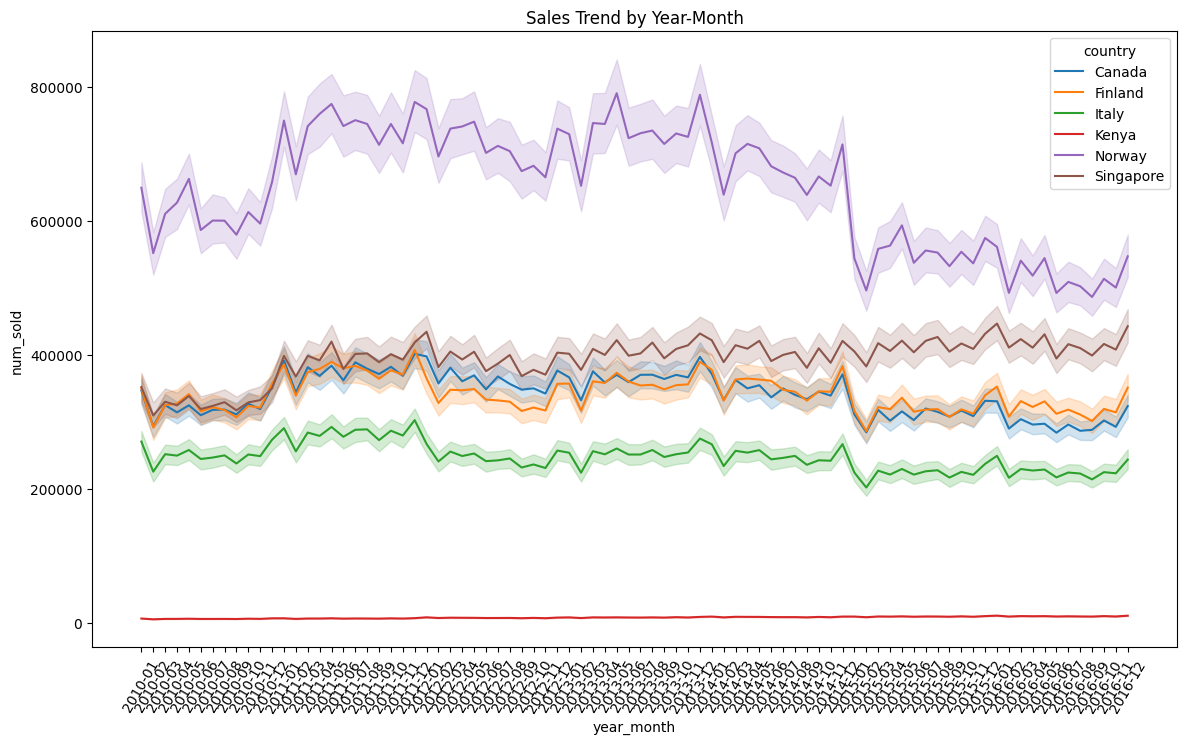

In [3]:
plt.figure(figsize=(14,8))
sns.lineplot(data=train, x='year_month', y='num_sold', hue='country', estimator='sum')
plt.xticks(rotation=60)
plt.title("Sales Trend by Year-Month")
plt.show() # From the graph, there are strong shift around 2010-11 and 2014-11, create a feature to indicate it(unpredictable event) 

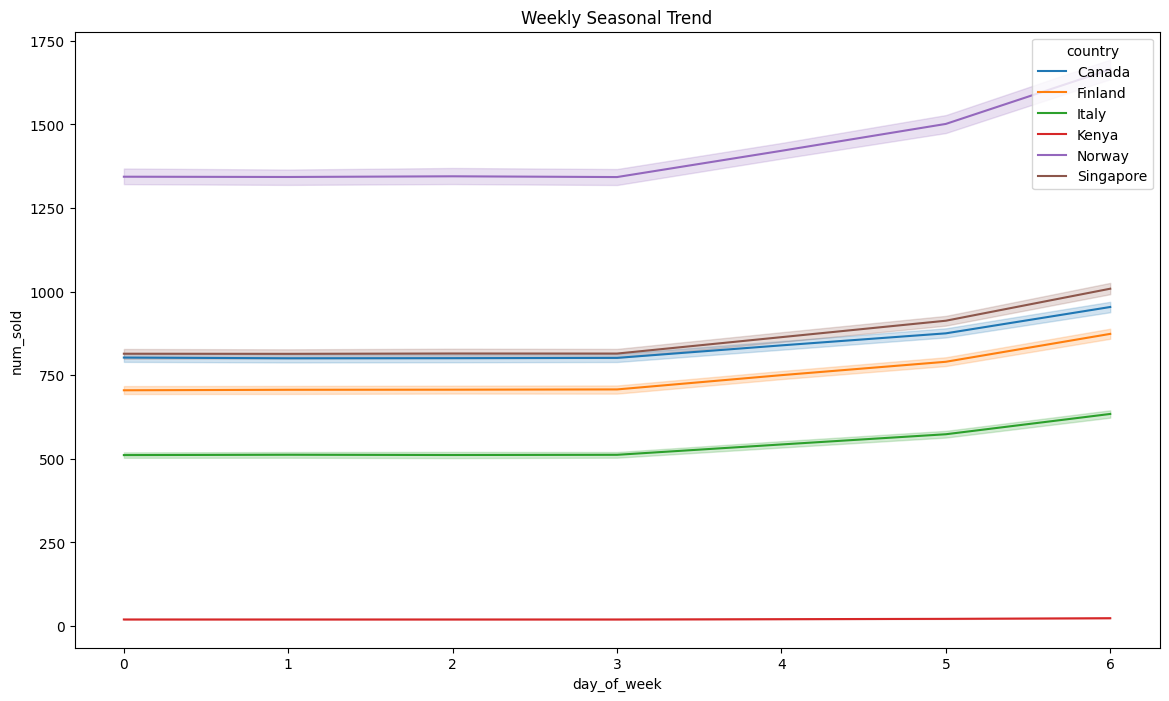

In [4]:
plt.figure(figsize=(14,8))
sns.lineplot(data=train, x='day_of_week', y='num_sold', hue='country')
plt.title('Weekly Seasonal Trend')
plt.show()

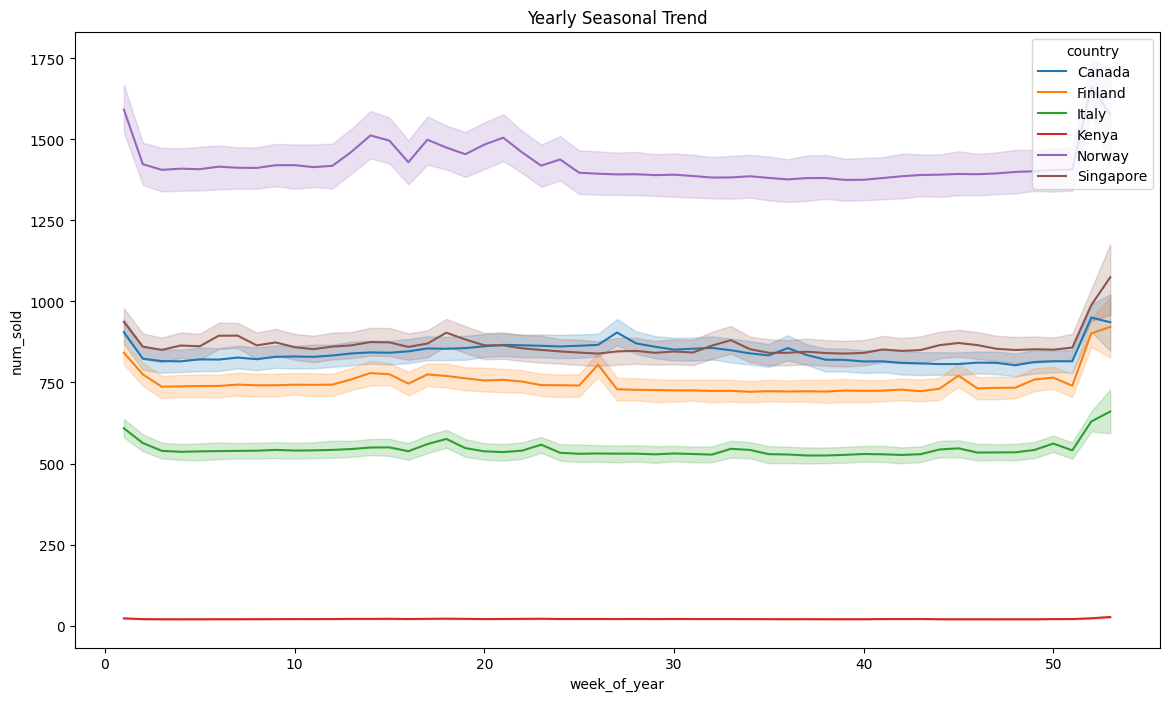

In [5]:
plt.figure(figsize=(14,8))
sns.lineplot(data=train, x='week_of_year', y='num_sold', hue='country')
plt.title('Yearly Seasonal Trend')
plt.show()

# Data Preprocessing

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
import optuna

train = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv', index_col='id')
train = train.dropna(subset=['num_sold'])
def convert_date(df):
    if df['date'].dtype == 'object':
        df['date'] = pd.to_datetime(df['date'])
        df['year'] = df['date'].dt.year
        df['quarter'] = df['date'].dt.quarter
        df['month'] = df['date'].dt.month
        df['day_of_week'] = df['date'].dt.dayofweek
        df['week_of_year'] = df['date'].dt.isocalendar().week
        df['day'] = df['date'].dt.day
        df = df.drop(['date'], axis=1)
        df['day_sin'] = np.sin(2 * np.pi * df['day'] / 365.0)
        df['day_cos'] = np.cos(2 * np.pi * df['day'] / 365.0)
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12.0)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12.0)
        df['year_sin'] = np.sin(2 * np.pi * df['year'] / 7.0)
        df['year_cos'] = np.cos(2 * np.pi * df['year'] / 7.0)
    return df
train = convert_date(train)
obj_cols = train.select_dtypes(['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
df_OHE = pd.DataFrame(encoder.fit_transform(train[obj_cols]), columns=encoder.get_feature_names_out(obj_cols))
train = train.drop(obj_cols, axis=1)
train = pd.concat([train.reset_index(drop=True), df_OHE.reset_index(drop=True)], axis=1)
y = train.pop('num_sold')
train.head()

,year,quarter,month,day_of_week,week_of_year,day,day_sin,day_cos,month_sin,month_cos,...,country_Norway,country_Singapore,store_Discount Stickers,store_Premium Sticker Mart,store_Stickers for Less,product_Holographic Goose,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode
0,2010,1,1,4,53,1,0.017213,0.999852,0.5,0.866025,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2010,1,1,4,53,1,0.017213,0.999852,0.5,0.866025,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2010,1,1,4,53,1,0.017213,0.999852,0.5,0.866025,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2010,1,1,4,53,1,0.017213,0.999852,0.5,0.866025,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2010,1,1,4,53,1,0.017213,0.999852,0.5,0.866025,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


# Model Training

In [7]:
def KFold_training(X, y, model_class, model_params):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    models = []
    mapes = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        model = model_class(**model_params)
        # Handle verbosity dynamically based on the model type
        if model_class.__name__ == "XGBRegressor":
            model = model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
        elif model_class.__name__ == "LGBMRegressor":
            model = model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric='mape'
            )
        elif model_class.__name__ == "CatBoostRegressor":
            model = model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False,
                early_stopping_rounds=10
            )
        models.append(model)
        y_pred = model.predict(X_val)
        y_train_pred = model.predict(X_train)
        mape_train = mean_absolute_percentage_error(y_train_pred, y_train)
        mape = mean_absolute_percentage_error(y_pred, y_val)
        mapes.append(mape)
        print(f'Fold {fold+1} mean absolute percentage error for train is {mape_train}, for val is {mape}')
    return models, mapes

def ensemble_prediction(models, X):
    prediction = np.zeros(X.shape[0])
    for model in models:
        prediction = prediction + model.predict(X)
    return prediction/len(models)

xgb_params = {'n_estimators': 154, 'learning_rate': 0.041259284876469744, 'max_depth': 11, 'reg_alpha': 0.3824592797131241, 'reg_lambda': 0.8898611011911761, 'min_child_weight': 3.136009988767917, 'subsample': 0.7084239409438348, 'colsample_bytree': 0.92333323939882,
              'eval_metric': 'mape',
              'random_state': 42,
              #'verbose': 1
             } # mape 0.07738683573065815
xgb_models, xgb_mapes = KFold_training(train, y, XGBRegressor, xgb_params)

X_val, y_val = train[-2000:], y[-2000:]

y_pred = ensemble_prediction(xgb_models, X_val)
mape = mean_absolute_percentage_error(y_pred, y_val)
print(f'mape for ensemble is {mape}')

lgbm_params = {'n_estimators': 323, 'learning_rate': 0.012674143622902619, 'max_depth': 8, 'reg_alpha': 1.0433133342521462e-07, 'reg_lambda': 0.006846316732584875, 'min_child_weight': 1.7330942171516812e-06, 'subsample': 0.5958328273307271, 'colsample_bytree': 0.9994225255726182, 'min_gain_to_split': 0.05679586852206272, 'min_data_in_leaf': 56,
    'metric': 'mape',
    'random_state': 42,
              } #mape 0.16090658431763868

lgbm_models, lgbm_mapes = KFold_training(train, y, LGBMRegressor, lgbm_params)
y_pred_lgbm = ensemble_prediction(lgbm_models, X_val)
mape = mean_absolute_percentage_error(y_pred_lgbm, y_val)
print(f'mape for lstm ensemble is {mape}')

cat_params = {'iterations': 235, 'learning_rate': 0.02769481482029079, 'depth': 12, 'l2_leaf_reg': 5.262311884722569, 'random_strength': 0.6256671980753346, 'bagging_temperature': 0.07816841460350965, 'border_count': 167,
              'random_seed': 42,
              'eval_metric': 'MAPE',
              'verbose': False} # mape 0.09356527897681086

cat_models, cat_mapes = KFold_training(train, y, CatBoostRegressor, cat_params)
y_pred_cat = ensemble_prediction(cat_models, X_val)
mape = mean_absolute_percentage_error(y_pred_cat, y_val)
print(f'mape for cat ensemble is {mape}')

Fold 1 mean absolute percentage error for train is 0.05011486243859996, for val is 0.05367720623203482
Fold 2 mean absolute percentage error for train is 0.04964418548586957, for val is 0.052910105525976005
Fold 3 mean absolute percentage error for train is 0.05007176642131721, for val is 0.05360139394132023
Fold 4 mean absolute percentage error for train is 0.050084285084989806, for val is 0.05392148313045567
Fold 5 mean absolute percentage error for train is 0.0496689012412811, for val is 0.05286755199187397
mape for ensemble is 0.04730758726592974
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_gain_to_split is set=0.05679586852206272, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05679586852206272
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored

In [8]:
y_pred_final = (0.4 * y_pred
               + 0.3 * y_pred_lgbm
               + 0.3 * y_pred_cat)
mape = mean_absolute_percentage_error(y_pred_final, y_val)
print(f'mape for cat ensemble is {mape}')

mape for cat ensemble is 0.09091773994374301


In [9]:
test = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv', index_col='id').sort_index()
test = convert_date(test)
df_test_OHE = pd.DataFrame(encoder.transform(test[obj_cols]), columns = encoder.get_feature_names_out(obj_cols))
test = test.drop(obj_cols, axis=1)
test = pd.concat([test.reset_index(drop=True), df_test_OHE.reset_index(drop=True)], axis=1)
test_pred_xgb = ensemble_prediction(xgb_models, test)
test_pred_lgbm = ensemble_prediction(lgbm_models, test)
test_pred_cat = ensemble_prediction(cat_models, test)
test_pred = (0.4 * test_pred_xgb
               + 0.3 * test_pred_lgbm
               + 0.3 * test_pred_cat)

sample = pd.read_csv('/kaggle/input/playground-series-s5e1/sample_submission.csv')
sample['num_sold'] = test_pred
sample.to_csv('submission.csv', index=False)
sample

[LightGBM] [Warning] min_gain_to_split is set=0.05679586852206272, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05679586852206272
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_gain_to_split is set=0.05679586852206272, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05679586852206272
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_gain_to_split is set=0.05679586852206272, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05679586852206272
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_gain_to_split is set=0.05679586852206272, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05679586852206272
[LightGBM]

,id,num_sold
0,230130,156.211919
1,230131,844.166217
2,230132,735.801862
3,230133,391.737531
4,230134,454.551446
...,...,...
98545,328675,362.389312
98546,328676,2065.022827
98547,328677,1728.697369
98548,328678,976.862593


In [10]:
#Tuning
'''def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),  # L2 regularization
        'min_child_weight': trial.suggest_float('min_child_weight', 0.5, 4),
        'subsample': trial.suggest_float('subsample', 0.2, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1),
        'random_state': 42,
        'eval_metric': 'mape'
    }
    xgb_models, mapes = KFold_training(train, y, XGBRegressor, params)
        
    return np.mean(mapes)
    
study = optuna.create_study(direction='minimize')
study.optimize(xgb_objective, n_trials=50, timeout=1000)

print("Best MAPE:", study.best_value)
print("Best Parameters:", study.best_params)


def lgbm_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),  # log scale
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),  # wider range
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),  # wider range
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-8, 4.0, log=True),  # adjusted
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # adjusted minimum
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'metric': 'mape',
        'verbose': -1  # suppress warnings
    }
    
    # Perform K-Fold cross-validation with LightGBM
    lgbm_models, mapes = KFold_training(train, y, LGBMRegressor, params)
    
    return np.mean(mapes)

# Create and optimize the study
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(lgbm_objective, n_trials=50, timeout=1000)

print("Best MAPE (LightGBM):", study_lgbm.best_value)
print("Best Parameters (LightGBM):", study_lgbm.best_params)


def cat_objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1),
        'depth': trial.suggest_int('depth', 5, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 10),
        'random_strength': trial.suggest_float('random_strength', 0, 1),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_seed': 42,
        'eval_metric': 'MAPE',  # CatBoost metric
        'verbose': False
    }
    cat_models, mapes = KFold_training(train, y, CatBoostRegressor, params)
    
    return np.mean(mapes)

study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(cat_objective, n_trials=50, timeout=1000)

print("Best MAPE (CatBoost):", study_cat.best_value)
print("Best Parameters (CatBoost):", study_cat.best_params)
'''

'def xgb_objective(trial):\n    params = {\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 100, 500),\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 1e-4, 0.1),\n        \'max_depth\': trial.suggest_int(\'max_depth\', 5, 12),\n        \'reg_alpha\': trial.suggest_float(\'reg_alpha\', 0, 1),  # L1 regularization\n        \'reg_lambda\': trial.suggest_float(\'reg_lambda\', 0, 1),  # L2 regularization\n        \'min_child_weight\': trial.suggest_float(\'min_child_weight\', 0.5, 4),\n        \'subsample\': trial.suggest_float(\'subsample\', 0.2, 1),\n        \'colsample_bytree\': trial.suggest_float(\'colsample_bytree\', 0.2, 1),\n        \'random_state\': 42,\n        \'eval_metric\': \'mape\'\n    }\n    xgb_models, mapes = KFold_training(train, y, XGBRegressor, params)\n        \n    return np.mean(mapes)\n    \nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(xgb_objective, n_trials=50, timeout=1000)\n\nprint("Best MAPE:", study.bes